# Recap of Measuring Broadband Performance

What are some of the limitations of SpeedTests ?

Home wireless network
At high speeds, WiFi is often the bottleneck

Newer devices support higher speeds
Measurement devices
available resources

Cross traffic
competing traffic from other senders
routers can account for cross traffic

What are the different types of speedtests, in particular answer whether they all use the same number of HTTP connections?

The mechanisms that Ookla and NDT7 use to (or attempt to) saturate the client-server path are quite different. NDT7 opens only a single TCP connection and runs for a fixed duration, ten seconds. Ookla, on the other hand, is known to use multiple TCP connections The latest versions of both Ookla and NDT7 use TCP websockets.

Approximately, what percentage of the total latency does the last mile latency account for ?

Last-mile is 40-80 % of end-to-end latency
High variance –> shared medium

# Analyzing Different Metrics related to Chunk Detection

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [21]:
df=pd.read_csv('/Users/haarika/Desktop/1-3/TA_section_codes/cs176c-discussion-section/spring24/week5/Recap + metric_calculation/data/transform_data.csv',sep='\t') #pandas version 

In [22]:
df.shape

(21342, 13)

In [23]:
df.head(5)

,ts,sIP,sPort,dIP,dPort,ip_len,ip_proto,tcp_flags,tcp_seq,tcp_ack,tls_hostname,dns_hostname,dns_ip
0,1.651793e+09,128.111.52.93,4505,192.168.1.138,47230,581,6,24.0,2.456833e+08,1.379606e+09,NaN,NaN,NaN
1,1.651793e+09,192.168.1.138,47230,128.111.52.93,4505,52,6,16.0,1.379606e+09,2.456839e+08,NaN,NaN,NaN
2,1.651793e+09,128.111.52.93,4505,192.168.1.138,47230,549,6,24.0,2.456839e+08,1.379606e+09,NaN,NaN,NaN
3,1.651793e+09,192.168.1.138,47230,128.111.52.93,4505,52,6,16.0,1.379606e+09,2.456843e+08,NaN,NaN,NaN
4,1.651793e+09,192.168.1.138,44848,128.111.52.93,4506,60,6,2.0,3.871087e+09,0.000000e+00,NaN,NaN,NaN


## The same analysis we did last week can also be done using pandas as well.

## googlevideo traffic

googlevideo.com is the domain owned by google used to store videos for YouTube.

In [27]:
df[['dns_ip', 'dns_hostname']].drop_duplicates().query("dns_hostname.str.contains('googlevideo', na=False)", engine='python')


,dns_ip,dns_hostname
4237,198.189.66.17,"r6---sn-jxopj-n5oe.googlevideo.com,r6.sn-jxopj..."
4238,198.189.66.17,"r6.sn-jxopj-n5oe.googlevideo.com,<Root>"
4239,NaN,"r6---sn-jxopj-n5oe.googlevideo.com,r6.sn-jxopj..."
4240,NaN,"r6.sn-jxopj-n5oe.googlevideo.com,<Root>"
5794,198.189.66.16,"rr5---sn-jxopj-n5oe.googlevideo.com,rr5.sn-jxo..."
5796,NaN,"rr5---sn-jxopj-n5oe.googlevideo.com,rr5.sn-jxo..."
5799,198.189.66.16,"rr5.sn-jxopj-n5oe.googlevideo.com,<Root>"
5801,NaN,"rr5.sn-jxopj-n5oe.googlevideo.com,<Root>"


In [15]:
df.select('dns_ip', 'dns_hostname').distinct().filter(
    df.dns_hostname.contains('googlevideo')).show(truncate=False)

+-------------+----------------------------------------------------------------------------+
|dns_ip       |dns_hostname                                                                |
+-------------+----------------------------------------------------------------------------+
|198.189.66.16|rr5---sn-jxopj-n5oe.googlevideo.com,rr5.sn-jxopj-n5oe.googlevideo.com,<Root>|
|198.189.66.17|r6---sn-jxopj-n5oe.googlevideo.com,r6.sn-jxopj-n5oe.googlevideo.com,<Root>  |
|198.189.66.16|rr5.sn-jxopj-n5oe.googlevideo.com,<Root>                                    |
|198.189.66.17|r6.sn-jxopj-n5oe.googlevideo.com,<Root>                                     |
|NULL         |rr5---sn-jxopj-n5oe.googlevideo.com,rr5.sn-jxopj-n5oe.googlevideo.com,<Root>|
|NULL         |r6.sn-jxopj-n5oe.googlevideo.com,<Root>                                     |
|NULL         |rr5.sn-jxopj-n5oe.googlevideo.com,<Root>                                    |
|NULL         |r6---sn-jxopj-n5oe.googlevideo.com,r6.sn-jxopj-n5oe.goo

In [22]:
df

,ts,sIP,sPort,dIP,dPort,ip_len,ip_proto,tcp_flags,tcp_seq,tcp_ack,tls_hostname,dns_hostname,dns_ip
0,1.651793e+09,128.111.52.93,4505,192.168.1.138,47230,581,6,24.0,2.456833e+08,1.379606e+09,NaN,NaN,NaN
1,1.651793e+09,192.168.1.138,47230,128.111.52.93,4505,52,6,16.0,1.379606e+09,2.456839e+08,NaN,NaN,NaN
2,1.651793e+09,128.111.52.93,4505,192.168.1.138,47230,549,6,24.0,2.456839e+08,1.379606e+09,NaN,NaN,NaN
3,1.651793e+09,192.168.1.138,47230,128.111.52.93,4505,52,6,16.0,1.379606e+09,2.456843e+08,NaN,NaN,NaN
4,1.651793e+09,192.168.1.138,44848,128.111.52.93,4506,60,6,2.0,3.871087e+09,0.000000e+00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21337,1.651793e+09,142.250.176.14,443,192.168.1.138,55745,238,17,NaN,NaN,NaN,NaN,NaN,NaN
21338,1.651793e+09,192.168.1.138,55745,142.250.176.14,443,60,17,NaN,NaN,NaN,NaN,NaN,NaN
21339,1.651793e+09,192.168.1.138,55745,142.250.176.14,443,67,17,NaN,NaN,NaN,NaN,NaN,NaN
21340,1.651793e+09,142.250.176.14,443,192.168.1.138,55745,56,17,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:

df[['dns_ip', 'dns_hostname']].drop_duplicates().query("dns_hostname.str.contains('googlevideo', na=False)", engine='python')




,dns_ip,dns_hostname
4237,198.189.66.17,"r6---sn-jxopj-n5oe.googlevideo.com,r6.sn-jxopj..."
4238,198.189.66.17,"r6.sn-jxopj-n5oe.googlevideo.com,<Root>"
4239,NaN,"r6---sn-jxopj-n5oe.googlevideo.com,r6.sn-jxopj..."
4240,NaN,"r6.sn-jxopj-n5oe.googlevideo.com,<Root>"
5794,198.189.66.16,"rr5---sn-jxopj-n5oe.googlevideo.com,rr5.sn-jxo..."
5796,NaN,"rr5---sn-jxopj-n5oe.googlevideo.com,rr5.sn-jxo..."
5799,198.189.66.16,"rr5.sn-jxopj-n5oe.googlevideo.com,<Root>"
5801,NaN,"rr5.sn-jxopj-n5oe.googlevideo.com,<Root>"


In [30]:
df[['sIP','sPort', 'dIP', 'dPort', 'ip_proto', 'tls_hostname']].query("tls_hostname.str.contains('googlevideo', na=False)", engine='python')

,sIP,sPort,dIP,dPort,ip_proto,tls_hostname
1250,192.168.1.138,41402,198.189.66.17,443,6,r6---sn-jxopj-n5oe.googlevideo.com
1258,192.168.1.138,41404,198.189.66.17,443,6,r6---sn-jxopj-n5oe.googlevideo.com
1429,192.168.1.138,46564,198.189.66.16,443,6,rr5---sn-jxopj-n5oe.googlevideo.com
1441,192.168.1.138,46566,198.189.66.16,443,6,rr5---sn-jxopj-n5oe.googlevideo.com
5716,192.168.1.138,39718,198.189.66.17,443,17,r6---sn-jxopj-n5oe.googlevideo.com
5873,192.168.1.138,50222,198.189.66.16,443,17,rr5---sn-jxopj-n5oe.googlevideo.com
19413,192.168.1.138,43937,198.189.66.16,443,17,rr5---sn-jxopj-n5oe.googlevideo.com


### Other interesting queries

**Query 1**: Source IP addresses along with the number of packets and the bytes (in B) they transferred.

Try writing this query yourself. You can remember the pyspark syntax we used last week and try implementing it in pandas instead



In [40]:
source_IPs = (
    df.groupby('sIP')
    .agg(ip_len_sum=('ip_len', 'sum'), count=('sIP', 'count'))
    .sort_values(by='ip_len_sum', ascending=False)
    .head(7)
)
print(source_IPs.to_string(index=True))


                ip_len_sum  count
sIP                              
198.189.66.16     19530980  14065
142.250.176.14     2426225   1998
99.84.192.24       2096701    502
192.168.1.138       437931   2933
142.250.176.22      231296    209
142.250.68.33       119359     52
142.250.72.227       70760     65


**Query 2**: Destination IP addresses along with the number of packets and the bytes (in B) transferred to them.

Try writing this query yourself. You can remember the pyspark syntax we used last week and try implementing it in pandas instead



In [41]:
dest_IPs = (
    df.groupby('dIP')
    .agg(ip_len_sum=('ip_len', 'sum'), count=('dIP', 'count'))
    .sort_values(by='ip_len_sum', ascending=False)
    .head(7)
)
print(dest_IPs.to_string(index=True))

                ip_len_sum  count
dIP                              
192.168.1.138     24957142  18407
142.250.176.14      131859    345
128.111.52.93        61452    687
198.189.66.16        47090    325
99.84.192.24         36608    357
192.168.1.1          14099    175
142.250.72.138       12510     58


**Query 3**: `142.250.176.14` is the second most prominent IP address in both queries 1 and 2. Let's see what hostname this IP belongs to

In [46]:
df[['sIP', 'sPort', 'dIP', 'dPort', 'ip_proto', 'tls_hostname']][
    (df['dIP'] == '142.250.176.14') & (df['tls_hostname'].notna())
]


,sIP,sPort,dIP,dPort,ip_proto,tls_hostname
1004,192.168.1.138,55104,142.250.176.14,443,6,www.youtube.com
3440,192.168.1.138,57212,142.250.176.14,443,6,www.youtube.com
3451,192.168.1.138,57214,142.250.176.14,443,6,www.youtube.com
3460,192.168.1.138,57216,142.250.176.14,443,6,www.youtube.com
4058,192.168.1.138,41465,142.250.176.14,443,17,www.youtube.com
21301,192.168.1.138,55745,142.250.176.14,443,17,www.youtube.com


**Query 4**: `99.84.192.24` ranks as the third most prominent source IP address which sends 2.1 Mb of data. Let's find out the hostname for this address

In [47]:
df[['sIP', 'sPort', 'dIP', 'dPort', 'ip_proto', 'tls_hostname']][
    (df['dIP'] == '99.84.192.24') & (df['tls_hostname'].notna())
]


,sIP,sPort,dIP,dPort,ip_proto,tls_hostname
185,192.168.1.138,38066,99.84.192.24,443,6,tracking-protection.cdn.mozilla.net
228,192.168.1.138,38070,99.84.192.24,443,6,tracking-protection.cdn.mozilla.net
253,192.168.1.138,38072,99.84.192.24,443,6,tracking-protection.cdn.mozilla.net
289,192.168.1.138,38074,99.84.192.24,443,6,tracking-protection.cdn.mozilla.net
331,192.168.1.138,38078,99.84.192.24,443,6,tracking-protection.cdn.mozilla.net
479,192.168.1.138,38080,99.84.192.24,443,6,tracking-protection.cdn.mozilla.net
887,192.168.1.138,38084,99.84.192.24,443,6,tracking-protection.cdn.mozilla.net
910,192.168.1.138,38086,99.84.192.24,443,6,tracking-protection.cdn.mozilla.net
932,192.168.1.138,38088,99.84.192.24,443,6,tracking-protection.cdn.mozilla.net
956,192.168.1.138,38092,99.84.192.24,443,6,tracking-protection.cdn.mozilla.net


## Isolating a flow for the video streaming session

A video streaming session consists of multiple flows. Let's isolate the biggest flow

In [54]:
multiple_flows= (
    df[(df['sIP'] == '198.189.66.16') & (df['dIP'] == '192.168.1.138')]
    .groupby(['sIP', 'sPort', 'dIP', 'dPort', 'ip_proto'])
    .agg(ip_len_sum=('ip_len', 'sum'), count=('ip_len', 'count'))
    .sort_values(by='ip_len_sum', ascending=False)
    .reset_index()
)

print(multiple_flows.to_string(index=False))

          sIP  sPort           dIP  dPort  ip_proto  ip_len_sum  count
198.189.66.16    443 192.168.1.138  50222        17    16753168  12148
198.189.66.16    443 192.168.1.138  43937        17     2500427   1811
198.189.66.16    443 192.168.1.138  46564         6      202465     70
198.189.66.16    443 192.168.1.138  46566         6       74920     36


## Constants and Functions

In [5]:
HOST_IP = "192.168.1.138"
YOUTUBE_IP = "198.189.66.16"
HOST_PORT = 50222
YOUTUBE_PORT = 443
TRANSPORT_PROTO = 17
GET_thresh = 300
DOWN_thresh = 300
VIDEO_thresh = 1000

Write the code to isolate the flow in pandas this time. That is store the flow in the dataframe. 

In [6]:

flow_df = (
    df[
        (((df['sIP'] == YOUTUBE_IP) & (df['dIP'] == HOST_IP) & (df['sPort'] == YOUTUBE_PORT) & (df['dPort'] == HOST_PORT)) |
         ((df['sIP'] == HOST_IP) & (df['dIP'] == YOUTUBE_IP) & (df['sPort'] == HOST_PORT) & (df['dPort'] == YOUTUBE_PORT))) &
        (df['ip_proto'] == TRANSPORT_PROTO)
    ]
    .sort_values('ts')
)

#flow_df['ts'] = flow_df['ts'] - flow_df['ts'].min()

flow_df['idx'] = range(1, len(flow_df) + 1)



In [7]:
flow_df.head(3)

,ts,sIP,sPort,dIP,dPort,ip_len,ip_proto,tcp_flags,tcp_seq,tcp_ack,tls_hostname,dns_hostname,dns_ip,idx
5873,1.651793e+09,192.168.1.138,50222,198.189.66.16,443,1385,17,NaN,NaN,NaN,rr5---sn-jxopj-n5oe.googlevideo.com,NaN,NaN,1
5874,1.651793e+09,198.189.66.16,443,192.168.1.138,50222,1385,17,NaN,NaN,NaN,NaN,NaN,NaN,2
5875,1.651793e+09,198.189.66.16,443,192.168.1.138,50222,1385,17,NaN,NaN,NaN,NaN,NaN,NaN,3


## Chunk Detection Algorithm

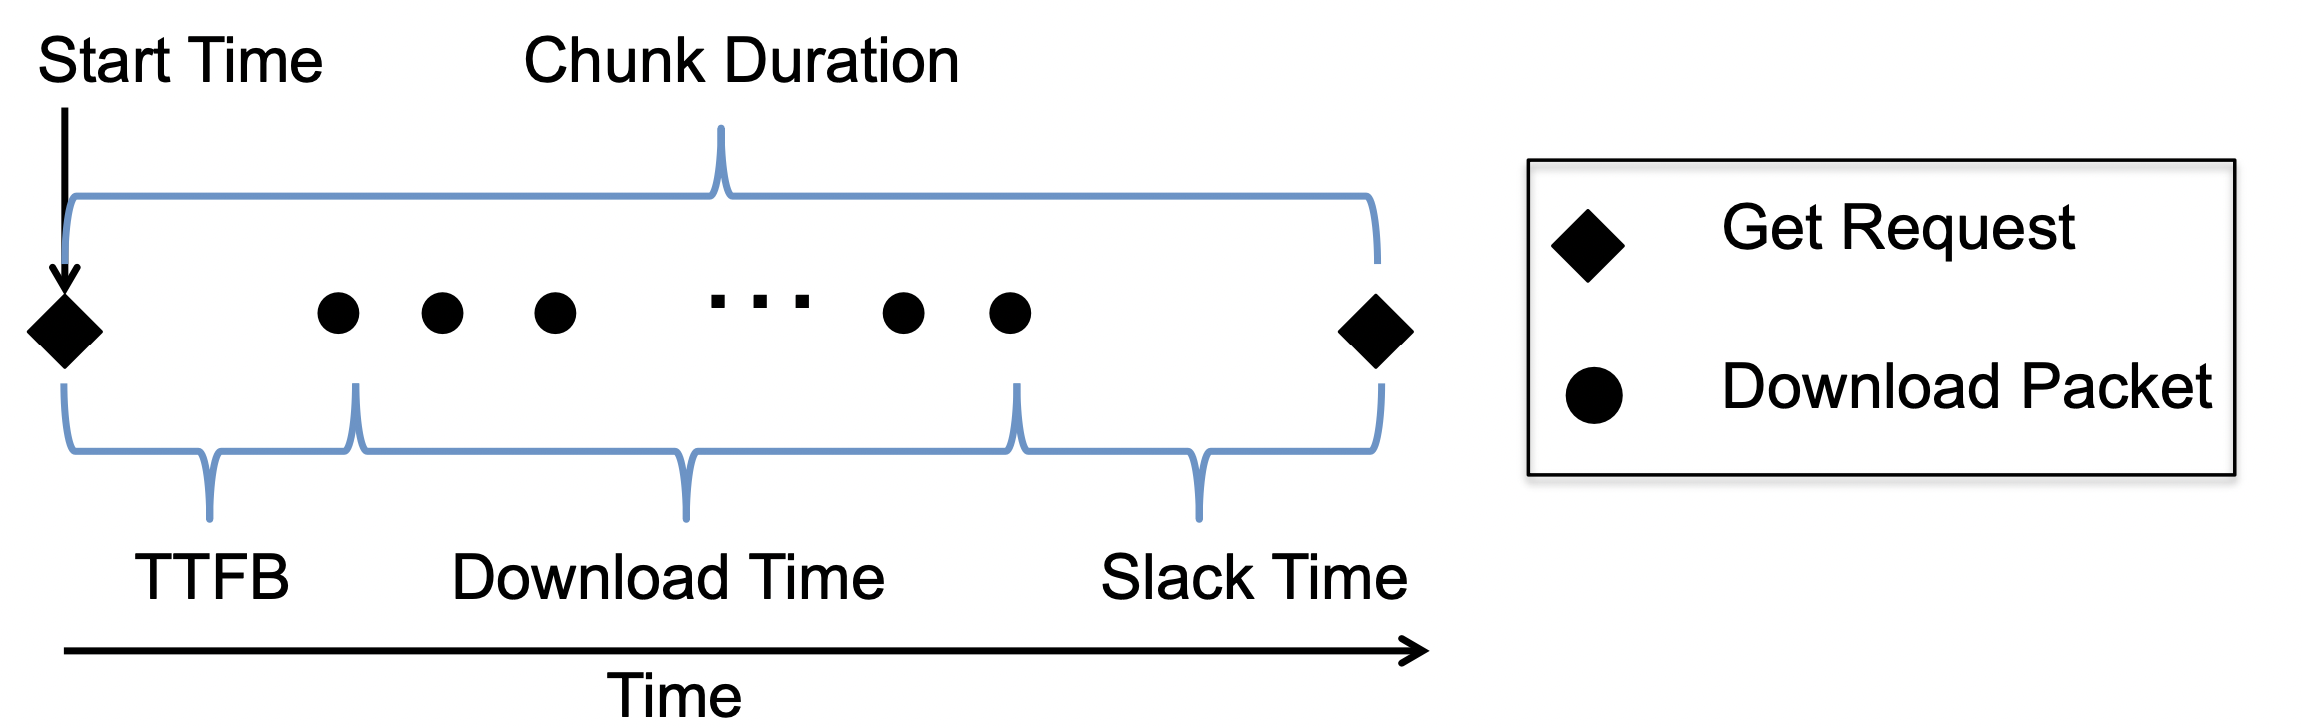

Credits: Requet: Real-Time QoE Detection for Encrypted YouTube Traffic (mmsys'19)

In [14]:
def get_request_indices():
    get_req_idx_df = flow_df[(flow_df['sIP'] == HOST_IP) & (flow_df['dIP'] == YOUTUBE_IP) & (flow_df['ip_len'] > GET_thresh) & (flow_df['ip_len'] > VIDEO_thresh)]
    return list(zip(get_req_idx_df['idx'], get_req_idx_df['ts']))

def chunk_detection():
    indices = get_request_indices()
    chunk_stats = []
    for i in range(len(indices)):
        curr_idx, curr_get_req_time = indices[i]
        next_idx, next_get_req_time = (None, None) if i == len(indices) - 1 else indices[i + 1]
        curr_chunk_df = flow_df[(flow_df['sIP'] == YOUTUBE_IP) & (flow_df['dIP'] == HOST_IP) & (flow_df['idx'] > curr_idx) & (flow_df['ip_len'] > DOWN_thresh)]
        if next_idx is not None:
            curr_chunk_df = curr_chunk_df[curr_chunk_df['idx'] < next_idx]

        chunk_size = curr_chunk_df['ip_len'].sum()
        if chunk_size < 80000:
            continue

        first_pkt_download_time = curr_chunk_df['ts'].min()
        last_pkt_download_time = curr_chunk_df['ts'].max()
        ttfb = first_pkt_download_time - curr_get_req_time
        if next_get_req_time!=None:
            chunk_duration=next_get_req_time-curr_get_req_time
        else: 
            chunk_duration=ttfb+last_pkt_download_time-first_pkt_download_time
        chunk_stats.append({
            'ttfb': ttfb,
            'chunk_size': chunk_size,
            'last_get_req_time': curr_get_req_time,
            'next_get_req_time': next_get_req_time,
            'first_pkt_download_time': first_pkt_download_time,
            'last_pkt_download_time': last_pkt_download_time,
            'download_time': last_pkt_download_time - first_pkt_download_time,
            'chunk_duration': chunk_duration
        })
    return chunk_stats

chunk_data = chunk_detection()


In [15]:
def get_request_indices():
    get_req_idx_df = flow_df[(flow_df['sIP'] == HOST_IP) & (flow_df['dIP'] == YOUTUBE_IP) & (flow_df['ip_len'] > GET_thresh) & (flow_df['ip_len'] > VIDEO_thresh)]
    return list(zip(get_req_idx_df['idx'], get_req_idx_df['ts']))

def chunk_detection():
    indices = get_request_indices()
    chunk_stats = []
    for i in range(len(indices)):
        curr_idx, curr_get_req_time = indices[i]
        next_idx, next_get_req_time = (None, None) if i == len(indices) - 1 else indices[i + 1]
        curr_chunk_df = flow_df[(flow_df['sIP'] == YOUTUBE_IP) & (flow_df['dIP'] == HOST_IP) & (flow_df['idx'] > curr_idx) & (flow_df['ip_len'] > DOWN_thresh)]
        if next_idx is not None:
            curr_chunk_df = curr_chunk_df[curr_chunk_df['idx'] < next_idx]

        chunk_size = curr_chunk_df['ip_len'].sum()
        if chunk_size < 80000:
            continue
        packet_count = curr_chunk_df.shape[0]
        first_pkt_download_time = curr_chunk_df['ts'].min()
        last_pkt_download_time = curr_chunk_df['ts'].max()
        ttfb = first_pkt_download_time - curr_get_req_time
        if next_get_req_time!=None:
            chunk_duration=next_get_req_time-curr_get_req_time
        else: 
            chunk_duration=ttfb+last_pkt_download_time-first_pkt_download_time
            print("hello")
        chunk_stats.append({
            'ttfb': ttfb,
            'chunk_size': chunk_size,
            'last_get_req_time': curr_get_req_time,
            'next_get_req_time': next_get_req_time,
            'first_pkt_download_time': first_pkt_download_time,
            'last_pkt_download_time': last_pkt_download_time,
            'download_time': last_pkt_download_time - first_pkt_download_time,
            'chunk_duration': chunk_duration,
            'packet_count_per_chunk':packet_count
        })
    return chunk_stats

chunk_data = chunk_detection()


hello


Practise Questions: 

Plot the CDF for the chunk size metric. You can look at the examples and use those to formulate how you will plot the CDF. Also plot a line plot. 

Compute the chunk duration metric for all chunks in the video stream and plot the CDF and line-plot.

Compute the packet count per chunk for all chunks in the video stream and plot the CDF and line-plot.

Calculate the maximum and minimum inter-arrival times between packets in the same chunk and plot the CDF and line-plot. 



### Plotting

In [9]:
def change_plot_params(ax, xlabel, ylabel, Xmin, Xmax, is_x_log=False, is_y_log=False):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if is_x_log:
        ax.set_xscale('log')
    if is_y_log:
        ax.set_yscale('log')
    if Xmin is not None:
        ax.set_xlim(xmin=Xmin)
    if Xmax is not None:
        ax.set_xlim(xmax=Xmax)
    ax.grid(True)
    return

def get_color_and_linestyle_kwargs(i):
    color_n = ['r', 'b', 'k', 'g', 'm', 'c', 'y']
    linestyles = ['-', '--', ':', '-.']
    return {'color': color_n[i % len(color_n)], 'linestyle': linestyles[i % len(linestyles)]}

def plotCDF(ax, data, labels, xlabel, ylabel, Xmax=None, Xmin=None, log_scale=False,
            set_legend=True, color_n_linestyle_dicts=None):
    raw = {}
    markers = ['o', '*', '^', '1', '4', 's', 'd', '3', 'd', 'o', '*', '^']

    for key in sorted(labels):
        raw[key] = list(data[key])
        if len(raw[key]) == 0:
            continue

        elms, cts = np.unique(raw[key], return_counts=True)
        cdf = np.cumsum(cts)
        cdf = cdf / cdf[-1]
        kwargs_dict = (get_color_and_linestyle_kwargs(key) if color_n_linestyle_dicts is None
                       else color_n_linestyle_dicts[key])
        ax.step(list(elms[:1]) + list(elms), [0] + list(cdf), where='post',
                label=labels[key], **kwargs_dict)

    # pl.legend((p),legnd,'lower right')
    if len(labels) > 1 and set_legend:
        set_legend_to_right(ax)

    change_plot_params(ax, xlabel, ylabel, Xmin, Xmax, is_x_log=log_scale)
    ax.set_ylim(ymax=1.0)
    ax.set_ylim(ymin=0.0)

In [10]:
ttfb_data = [x['ttfb'] * 1000 for x in chunk_data]

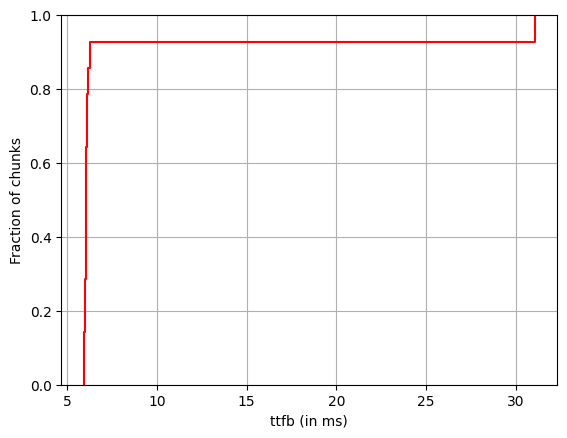

In [11]:
plotCDF(plt.gca(), {0: ttfb_data}, {0: ''}, 'ttfb (in ms)', 'Fraction of chunks')
plt.show()

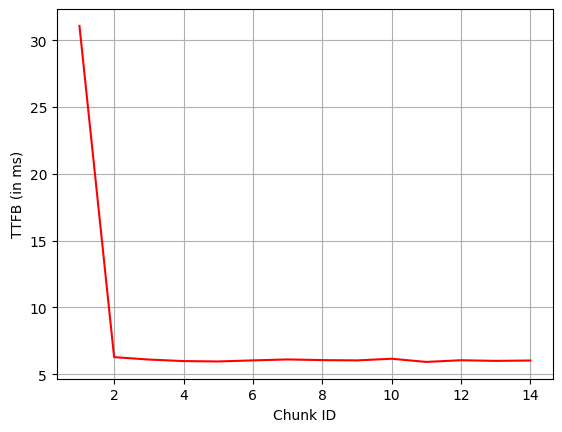

In [144]:
def line_plot():
    chunk_ids = range(1, 1 + len(chunk_data))
    plt.plot(chunk_ids, ttfb_data, **get_color_and_linestyle_kwargs(0))
    change_plot_params(plt.gca(), 'Chunk ID', 'TTFB (in ms)', None, None, is_x_log=False, is_y_log=False)
    return

line_plot()
plt.show()

#### Cumulative Distribution Function (CDF)

chunk_size = [x['chunk_size'] for x in chunk_data]
plotCDF(plt.gca(), {0: chunk_size}, {0: ''}, 'Chunk Size (in bytes)', 'Fraction of chunks')
plt.show()
Question 2: Answer
chunk_duration = [x['chunk_duration']*1000 for x in chunk_data]
plotCDF(plt.gca(), {0:chunk_duration}, {0: ''}, 'Chunk Duration (in ms)', 'Fraction of chunks')
plt.show()
Question 3:
packet_count = [x['packet_count_per_chunk']for x in chunk_data]
plotCDF(plt.gca(), {0: packet_count}, {0: ''}, 'Packet Count Per Chunk', 'Fraction of chunks')
plt.show()

def line_plot():
    chunk_ids = range(1, 1 + len(chunk_data))
    plt.plot(chunk_ids,packet_count , **get_color_and_linestyle_kwargs(0))
    change_plot_params(plt.gca(), 'Chunk ID', 'Packet Count per Chunk', None, None, is_x_log=False, is_y_log=False)
    return

line_plot()
plt.show()

Question 1: Answer

In [12]:
chunk_size = [x['chunk_size'] for x in chunk_data]

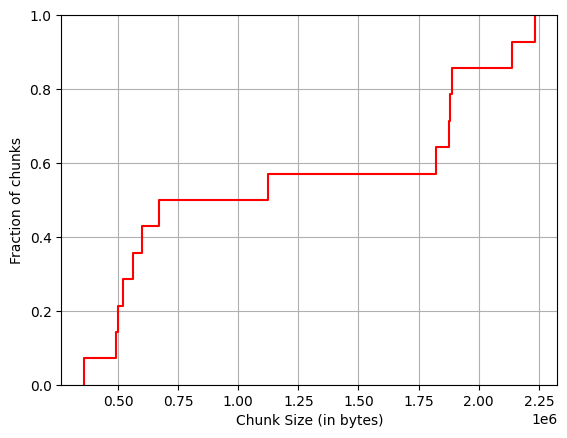

In [13]:
plotCDF(plt.gca(), {0: chunk_size}, {0: ''}, 'Chunk Size (in bytes)', 'Fraction of chunks')
plt.show()

Question 2: Answer

In [16]:
chunk_duration = [x['chunk_duration']*1000 for x in chunk_data]

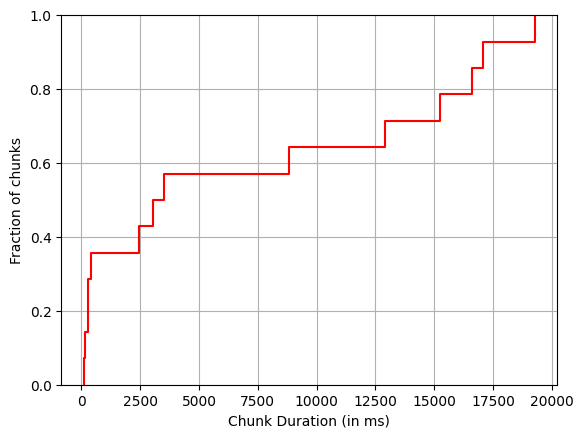

In [17]:
plotCDF(plt.gca(), {0:chunk_duration}, {0: ''}, 'Chunk Duration (in ms)', 'Fraction of chunks')
plt.show()

Question 3:

In [18]:
packet_count = [x['packet_count_per_chunk']for x in chunk_data]

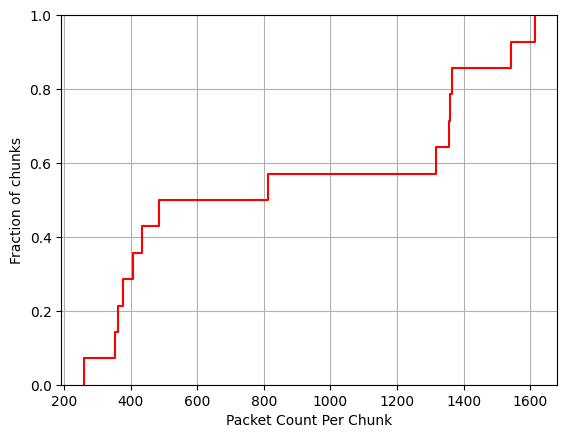

In [19]:
plotCDF(plt.gca(), {0: packet_count}, {0: ''}, 'Packet Count Per Chunk', 'Fraction of chunks')
plt.show()

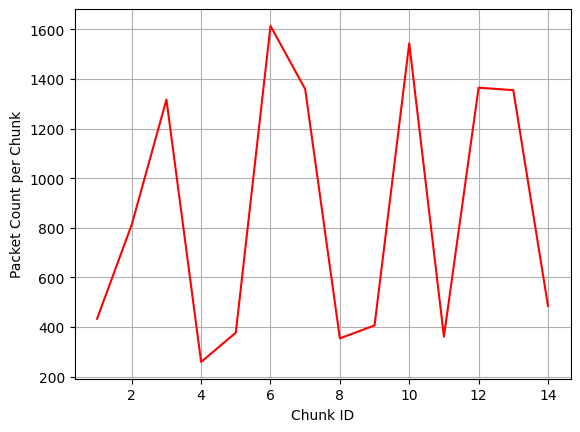

In [20]:

def line_plot():
    chunk_ids = range(1, 1 + len(chunk_data))
    plt.plot(chunk_ids,packet_count , **get_color_and_linestyle_kwargs(0))
    change_plot_params(plt.gca(), 'Chunk ID', 'Packet Count per Chunk', None, None, is_x_log=False, is_y_log=False)
    return

line_plot()
plt.show()